In [87]:
from preprocess_dataset import load_dataset
import scipy
import scipy.stats as stats
import numpy as np

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from time import time
import matplotlib.pyplot as plt
import pandas as pd

from edward.models import Dirichlet, Categorical, InverseGamma, ParamMixture, Normal

plt.style.use('ggplot')

In [2]:
data, genes, cells = load_dataset(filter_std=0.75)
print("Data shape:", data.shape)

Number of cells: 4645
Number of genes: 23686
After cutting out stop genes:
	Number of cells: 4645
	Number of genes: 23675
After cutting out ribosomal protein genes:
	Number of cells: 4645
	Number of genes: 23552
After cutting out all-zero rows [cells]:
	Number of cells: 4645
	Number of genes: 23552
After cutting out all-zero columns [genes]:
	Number of cells: 4645
	Number of genes: 22712
After cutting out the bottom 0.750000 fraction of genes with low STD (<8.053897):
	Number of cells: 4645
	Number of genes: 5678
Data shape: (4645, 5678)


In [3]:
pca = PCA(n_components=2)
pca.fit(data)
dim_reduced_data = pca.transform(data)

In [4]:
dim_reduced_data.shape

(4645, 2)

In [5]:
pca = PCA(n_components=1)
pca.fit(data)
mixture_reduced_data = pca.transform(data)

In [7]:
mixture_reduced_data.shape

(4645, 1)

In [9]:
def compute_stats(data):
    tmp = np.count_nonzero(data, axis=1)
    print("Average/Min/Max non-zero count for each cell: ", np.mean(tmp), np.min(tmp), np.max(tmp))
    tmp = np.count_nonzero(data, axis=0)
    print("Average/Min/Max non-zero count for each gene: ", np.mean(tmp), np.min(tmp), np.max(tmp))
    tmp = np.max(data, axis=0)
    print("Average/Min/Max max-expression value for each gene: ", np.mean(tmp), np.min(tmp), np.max(tmp))
    print("Number of genes with max-expression of 1:", np.where(tmp==1)[0].shape[0])
    # mean non-zero expression value of each gene
    tmp = np.true_divide(data.sum(0),(data!=0).sum(0))
    print("Average/Min/Max mean non-zero expression value for each gene: ", np.mean(tmp), np.min(tmp), np.max(tmp))
    
def normalize_along_columns(data):
    return (data - data.mean(axis=0)) / data.std(axis=0)

In [10]:
compute_stats(dim_reduced_data)
dim_reduced_data_norm = normalize_along_columns(dim_reduced_data)
compute_stats(dim_reduced_data_norm)

Average/Min/Max non-zero count for each cell:  2.0 2 2
Average/Min/Max non-zero count for each gene:  4645.0 4645 4645
Average/Min/Max max-expression value for each gene:  32850.5346718 5441.56316267 60259.5061809
Number of genes with max-expression of 1: 0
Average/Min/Max mean non-zero expression value for each gene:  -2.07212312134e-13 -2.62067129151e-13 -1.52357495117e-13
Average/Min/Max non-zero count for each cell:  2.0 2 2
Average/Min/Max non-zero count for each gene:  4645.0 4645 4645
Average/Min/Max max-expression value for each gene:  21.1832616109 4.80988070845 37.5566425133
Number of genes with max-expression of 1: 0
Average/Min/Max mean non-zero expression value for each gene:  4.2774807736e-16 8.32278869671e-17 7.72268267754e-16


In [11]:
compute_stats(mixture_reduced_data)
mixture_reduced_data_norm = normalize_along_columns(mixture_reduced_data)
compute_stats(mixture_reduced_data_norm)

Average/Min/Max non-zero count for each cell:  1.0 1 1
Average/Min/Max non-zero count for each gene:  4645.0 4645 4645
Average/Min/Max max-expression value for each gene:  60259.5061796 60259.5061796 60259.5061796
Number of genes with max-expression of 1: 0
Average/Min/Max mean non-zero expression value for each gene:  -6.26562550199e-15 -6.26562550199e-15 -6.26562550199e-15
Average/Min/Max non-zero count for each cell:  1.0 1 1
Average/Min/Max non-zero count for each gene:  4645.0 4645 4645
Average/Min/Max max-expression value for each gene:  37.5566425125 37.5566425125 37.5566425125
Number of genes with max-expression of 1: 0
Average/Min/Max mean non-zero expression value for each gene:  1.22375498086e-17 1.22375498086e-17 1.22375498086e-17


In [69]:
mixture_reduced_data_norm = mixture_reduced_data_norm.squeeze()
mixture_reduced_data_norm_trn,mixture_reduced_data_norm_test = mixture_reduced_data_norm[0:2323],mixture_reduced_data_norm[2322:]

In [70]:
mixture_reduced_data_norm.shape, mixture_reduced_data_norm_trn.shape, mixture_reduced_data_norm_test.shape

((4645,), (2323,), (2323,))

In [71]:
n_data = len(mixture_reduced_data_norm_trn)
n_feats = 1
cluster_assignments = [None]*5

In [79]:
for clust_i, n_clusters in enumerate([10,25,50,75,100]):
    print("Number of clusters:", n_clusters)
    pi_alpha = np.ones(n_clusters, dtype=np.float32)
    mu_sigma = np.std(np.random.rand(n_clusters))
    sigmasq_alpha = 1.0
    sigmasq_beta = 2.0

    pi = Dirichlet(pi_alpha)
    mu = Normal(0.0, mu_sigma.astype('float32'), sample_shape=n_clusters)
    sigmasq = InverseGamma(sigmasq_alpha, sigmasq_beta, sample_shape=n_clusters)
    x = ParamMixture(pi, {'loc': mu, 'scale': tf.sqrt(sigmasq)}, Normal, sample_shape=n_data)
    z = x.cat

    # Conditionals
    mu_cond = ed.complete_conditional(mu)
    sigmasq_cond = ed.complete_conditional(sigmasq)
    pi_cond = ed.complete_conditional(pi)
    z_cond = ed.complete_conditional(z)

    sess = ed.get_session()

    # Initialize randomly
    pi_est, mu_est, sigmasq_est, z_est = sess.run([pi, mu, sigmasq, z])
    # print('Initial parameters:', 'pi:', pi_est, 'mu:', mu_est, 'sigmasq:', sigmasq_est)
    
    # Gibbs sampler
    print("sampling...")
    cond_dict = {pi: pi_est, mu: mu_est, sigmasq: sigmasq_est, z: z_est, x: mixture_reduced_data_norm_trn}
    t0 = time()
    T = 500
    for t in range(T):
        if t % 100 == 0: print("\t on",t, "of", T)
        z_est = sess.run(z_cond, cond_dict)
        cond_dict[z] = z_est
        pi_est, mu_est = sess.run([pi_cond, mu_cond], cond_dict)
        cond_dict[pi] = pi_est
        cond_dict[mu] = mu_est
        sigmasq_est = sess.run(sigmasq_cond, cond_dict)
        cond_dict[sigmasq] = sigmasq_est
    print('took %.3f seconds to run %d iterations' % (time() - t0, T))
    
    cluster_assignments[clust_i] = z_est[:]
    
    ll = ed.evaluate('log_likelihood', data={x: mixture_reduced_data_norm_test.astype('float32')})
    print("\tlog likelihood:", ll)

Number of clusters: 10
sampling...
	 on 0 of 500
	 on 100 of 500
	 on 200 of 500
	 on 300 of 500
	 on 400 of 500
took 13.664 seconds to run 500 iterations
	log likelihood: -2.05636
Number of clusters: 25
sampling...
	 on 0 of 500
	 on 100 of 500
	 on 200 of 500
	 on 300 of 500
	 on 400 of 500
took 23.811 seconds to run 500 iterations
	log likelihood: -2.07047
Number of clusters: 50
sampling...
	 on 0 of 500
	 on 100 of 500
	 on 200 of 500
	 on 300 of 500
	 on 400 of 500
took 42.560 seconds to run 500 iterations
	log likelihood: -2.08082
Number of clusters: 75
sampling...
	 on 0 of 500
	 on 100 of 500
	 on 200 of 500
	 on 300 of 500
	 on 400 of 500
took 56.772 seconds to run 500 iterations
	log likelihood: -2.07899
Number of clusters: 100
sampling...
	 on 0 of 500
	 on 100 of 500
	 on 200 of 500
	 on 300 of 500
	 on 400 of 500
took 74.161 seconds to run 500 iterations
	log likelihood: -2.06194


In [77]:
# [10,25,50,75,100]
for i in range(5):
    print(i,len(set(cluster_assignments_final[i])))

0 3
1 9
2 16
3 18
4 20


In [83]:
names = np.load('/home/skoppula/Desktop/complete_cell_names.npy')
lbls = np.load('/home/skoppula/Desktop/complete_cell_labels.npy')

In [85]:
names

array(['Cy72_CD45_H02_S758_comb', 'CY58_1_CD45_B02_S974_comb',
       'Cy71_CD45_D08_S524_comb', ..., 'CY75_1_CD45_CD8_1__S93_comb',
       'CY75_1_CD45_CD8_1__S76_comb', 'CY75_1_CD45_CD8_7__S274_comb'], 
      dtype='<U48')

In [86]:
cells

array(['Cy72_CD45_H02_S758_comb', 'CY58_1_CD45_B02_S974_comb',
       'Cy71_CD45_D08_S524_comb', ..., 'CY75_1_CD45_CD8_1__S93_comb',
       'CY75_1_CD45_CD8_1__S76_comb', 'CY75_1_CD45_CD8_7__S274_comb'], dtype=object)

In [89]:
set(lbls)

{'0', '1', '2', '3', '4', '5', '6', '7'}

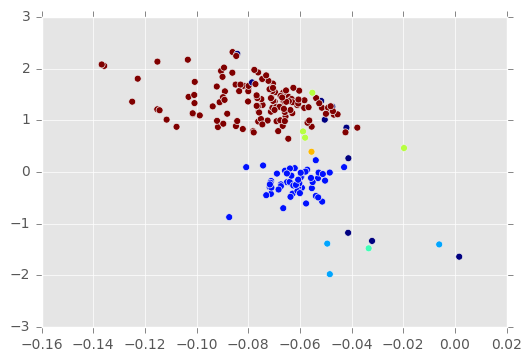

In [102]:
plt.clf()
colors = lbls[1000:1200]
plt.scatter(dim_reduced_data_norm[1000:1200,0], dim_reduced_data_norm[1000:1200,1], c=colors,s=25)
plt.show()

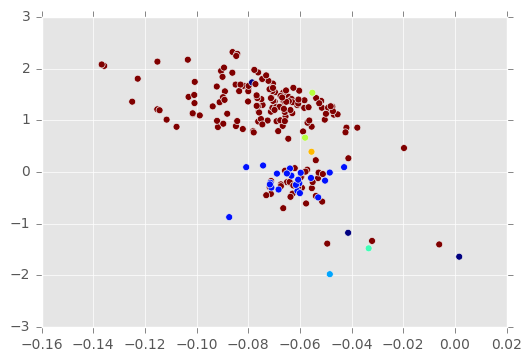

In [116]:
plt.clf()
colors = np.concatenate((cluster_assignments_final[0][1000:1100], lbls[1100:1200]), axis=0)
plt.scatter(dim_reduced_data_norm[1000:1200,0], dim_reduced_data_norm[1000:1200,1], c=colors,s=25)
plt.show()

In [114]:
cluster_assignments_final[4][1000:1100]

array([55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55,
       55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55], dtype=int32)

In [90]:
dim_reduced_data_norm

array([[ 0.11713105, -2.28845406],
       [-0.0552185 , -0.27107091],
       [-0.08623991,  0.07285848],
       ..., 
       [-0.04746938,  0.04051731],
       [-0.05462023,  0.29573089],
       [-0.04952176,  0.15998941]])